In [119]:
# install the necessary libraries
!pip install alpaca-trade-api
!pip install pandas
!pip install numpy
!pip install xgboost
!pip install matplotlib
!pip install scikit-learn


In [402]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error


In [403]:
# define the date range for the data
start_date = pd.Timestamp("2016-01-01", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2023-03-24", tz="America/New_York").isoformat()


In [404]:
# retrieve the historical bar data for SOYB
soyb_bars = api.get_bars("SOYB", "1D", start=start_date, end=end_date).df


In [405]:
# define the columns we need
columns = ["close", "volume", "trade_count", "vwap"]


In [406]:
# retrieve the historical bar data for SOYB
soyb_bars = api.get_bars("SOYB", "1D", start=start_date, end=end_date).df


In [407]:
# define the columns we need
columns = ["close", "volume", "trade_count", "vwap"]


In [408]:
# create an empty dataframe with the required columns
data = pd.DataFrame(columns=columns)


In [409]:
# fill the dataframe with data
data["close"] = soyb_bars["close"]
data["volume"] = soyb_bars["volume"]
data["trade_count"] = soyb_bars["trade_count"]
data["vwap"] = soyb_bars["vwap"]

In [414]:
# add the timestamp column to the dataframe
data["timestamp"] = soyb_bars.index


In [415]:
print(data.head())


                             close  volume  trade_count       vwap  SMA50  \
timestamp                                                                   
2016-01-04 05:00:00+00:00  17.2290   91243          127  17.193260    NaN   
2016-01-05 05:00:00+00:00  17.1934    6095           39  17.268416    NaN   
2016-01-06 05:00:00+00:00  17.2645   12762           31  17.120849    NaN   
2016-01-07 05:00:00+00:00  17.3195   11035           42  17.297185    NaN   
2016-01-08 05:00:00+00:00  17.3300   22296           69  17.375691    NaN   

                           SMA200  prev_close  prev_volume  prev_trade_count  \
timestamp                                                                      
2016-01-04 05:00:00+00:00     NaN         NaN          NaN               NaN   
2016-01-05 05:00:00+00:00     NaN     17.2290      91243.0             127.0   
2016-01-06 05:00:00+00:00     NaN     17.1934       6095.0              39.0   
2016-01-07 05:00:00+00:00     NaN     17.2645      12762.0  

In [416]:
# calculate SMA50 and SMA200 signals
data["SMA50"] = data["close"].rolling(window=50).mean()
data["SMA200"] = data["close"].rolling(window=200).mean()


In [417]:
# calculate previous closing prices, volume, trade counts, and vwap
data["prev_close"] = data["close"].shift()
data["prev_volume"] = data["volume"].shift()
data["prev_trade_count"] = data["trade_count"].shift()
data["prev_vwap"] = data["vwap"].shift()

# add timestamp to the new columns
data["prev_close_timestamp"] = data["timestamp"].shift()
data["prev_volume_timestamp"] = data["timestamp"].shift()
data["prev_trade_count_timestamp"] = data["timestamp"].shift()
data["prev_vwap_timestamp"] = data["timestamp"].shift()


In [418]:
df = pd.concat([data["timestamp"], data.drop("timestamp", axis=1)], axis=1)
print(df)


                                          timestamp    close  volume  \
timestamp                                                              
2016-01-04 05:00:00+00:00 2016-01-04 05:00:00+00:00  17.2290   91243   
2016-01-05 05:00:00+00:00 2016-01-05 05:00:00+00:00  17.1934    6095   
2016-01-06 05:00:00+00:00 2016-01-06 05:00:00+00:00  17.2645   12762   
2016-01-07 05:00:00+00:00 2016-01-07 05:00:00+00:00  17.3195   11035   
2016-01-08 05:00:00+00:00 2016-01-08 05:00:00+00:00  17.3300   22296   
...                                             ...      ...     ...   
2023-03-20 04:00:00+00:00 2023-03-20 04:00:00+00:00  27.0900   21903   
2023-03-21 04:00:00+00:00 2023-03-21 04:00:00+00:00  26.8100   19168   
2023-03-22 04:00:00+00:00 2023-03-22 04:00:00+00:00  26.3300   21120   
2023-03-23 04:00:00+00:00 2023-03-23 04:00:00+00:00  25.9645   26105   
2023-03-24 04:00:00+00:00 2023-03-24 04:00:00+00:00  26.2900   17559   

                           trade_count       vwap     SMA50    

In [419]:
# calculate previous SMA50 and SMA200 signals
data["prev_SMA50"] = data["SMA50"].shift()
data["prev_SMA200"] = data["SMA200"].shift()

In [420]:
# calculate Signal and Entry/Exit signals
data["Signal"] = np.where(data["SMA50"] > data["SMA200"], 1, -1)
data["Entry/Exit"] = data["Signal"].diff()


In [421]:
# filter the data to only include rows up to the end_date
data_filtered = data.loc[:end_date]


In [422]:
# select the training and testing data
train_data = data_filtered.loc["2021-04-01":"2022-03-31"]
test_data = data_filtered.loc["2022-04-01":"2023-03-24"]


In [423]:
# select the features and target variables for training data
train_features = train_data[["close", "SMA50", "SMA200", "prev_close", "prev_volume", "prev_trade_count", "prev_vwap"]]
train_target = train_data["Entry/Exit"]


In [424]:
# select the features and target variables for testing data
test_features = test_data[["close", "SMA50", "SMA200", "prev_close", "prev_volume", "prev_trade_count", "prev_vwap"]]
test_target = test_data["Entry/Exit"]


In [425]:
# encode the target variable
le = LabelEncoder()
train_target = le.fit_transform(train_target)
test_target = le.transform(test_target)

In [426]:
# Define the XGBoost Model
model = xgb.XGBClassifier(max_depth=2, learning_rate=0.1, n_estimators=100, objective="multi:softmax", num_class=3, verbosity=0)


In [427]:
# train the model on the training data
model.fit(train_features, train_target)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_class=3,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [431]:
# select the features and target variables for testing data
test_features = test_data[["close", "SMA50", "SMA200", "prev_close", "prev_volume", "prev_trade_count", "prev_vwap"]]
test_target = test_data["Entry/Exit"]


In [433]:
# concatenate the training and test sets
data = pd.concat([train_data, test_data])

# select the features and target variables
features = ["close", "SMA50", "SMA200", "prev_close", "prev_volume", "prev_trade_count", "prev_vwap"]
target = "Entry/Exit"

# encode the target variable
le = LabelEncoder()
data[target] = le.fit_transform(data[target])

# split the data back into training and test sets
train_data = data[data["timestamp"] < "2022-04-01"]
test_data = data[data["timestamp"] >= "2022-04-01"]

train_features = train_data[features]
train_target = train_data[target]
test_features = test_data[features]
test_target = test_data[target]


In [434]:
# make predictions on the test data
y_pred = model.predict(test_features)

In [435]:
#calculate the accuracy score of the model

accuracy = model.score(test_features, test_target)
print(f"Model Accuracy: {accuracy}")

Model Accuracy: 0.991869918699187


In [436]:
# predict closing prices using the trained model
test_data["predicted_close"] = model.predict(test_features)



/var/folders/3d/4j6nwr2j7hxbsh1g9xfq6nmr0000gn/T/ipykernel_22698/2107841176.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["predicted_close"] = model.predict(test_features)


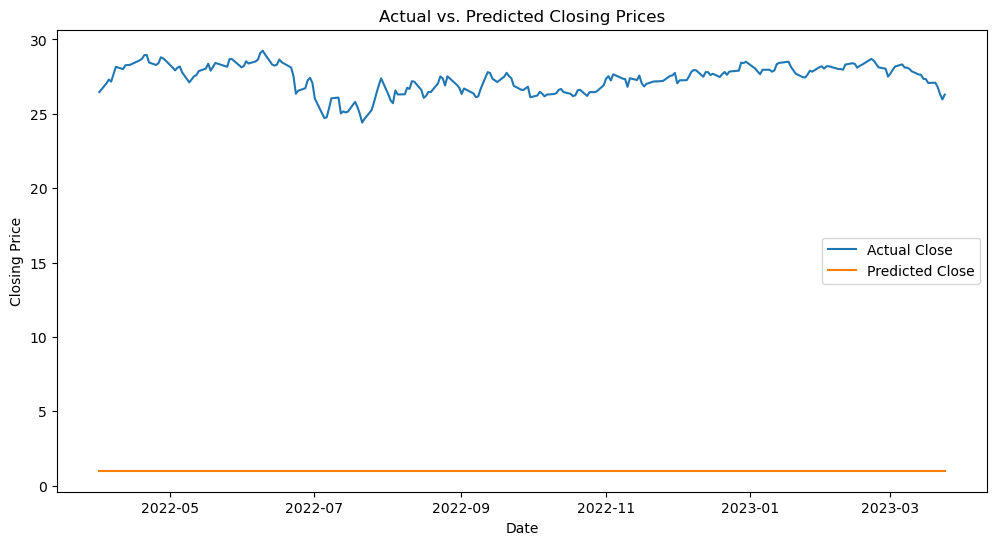

In [437]:
#plot actual and predicted closing prices

plt.figure(figsize=(12,6))
plt.plot(test_data.index, test_data["close"], label="Actual Close")
plt.plot(test_data.index, test_data["predicted_close"], label="Predicted Close")
plt.legend()
plt.title("Actual vs. Predicted Closing Prices")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.show()

In [438]:
#calculate R-squared and RMSE for the model

r_squared = r2_score(test_data["close"], test_data["predicted_close"])
rmse = mean_squared_error(test_data["close"], test_data["predicted_close"], squared=False)
print(f"R-squared: {r_squared}")
print(f"RMSE: {rmse}")

R-squared: -777.2571037763468
RMSE: 26.370778542433385


In [ ]:
# As we can see the intial XGBOOST model performed quite poorly. Therefore, we decided to figure out a way to optimize the model.

In [ ]:
# In doing so, we used optimnal hyperparameteres to fine tune the model. 

In [ ]:
# Optimized XGBoost Model

In [440]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error


In [442]:
# Retrieve historical bar data for SOYB
start_date = pd.Timestamp("2016-01-01", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2023-03-24", tz="America/New_York").isoformat()
soyb_bars = api.get_bars("SOYB", "1D", start=start_date, end=end_date).df


In [443]:
# Define the columns needed for training and testing
columns = ["close", "volume", "trade_count", "vwap", "SMA50", "SMA200"]


In [444]:
# Create an empty dataframe with the required columns
data = pd.DataFrame(columns=columns)


In [460]:
print (data)

                             close  volume  trade_count       vwap      SMA50  \
timestamp                                                                       
2016-10-18 04:00:00+00:00  18.9729   52816           99  18.990930  18.718530   
2016-10-19 04:00:00+00:00  19.1290   10234           30  19.078056  18.723910   
2016-10-20 04:00:00+00:00  18.9710   19228           47  19.136298  18.728130   
2016-10-21 04:00:00+00:00  19.1200   10004           35  19.096622  18.734616   
2016-10-24 04:00:00+00:00  19.2400    9271           48  19.289004  18.743416   
...                            ...     ...          ...        ...        ...   
2023-03-20 04:00:00+00:00  27.0900   21903          209  27.035517  27.980810   
2023-03-21 04:00:00+00:00  26.8100   19168          257  26.922124  27.957810   
2023-03-22 04:00:00+00:00  26.3300   21120          248  26.434687  27.925210   
2023-03-23 04:00:00+00:00  25.9645   26105          266  26.077453  27.887900   
2023-03-24 04:00:00+00:00  2

In [445]:
# Fill the dataframe with data
data["close"] = soyb_bars["close"]
data["volume"] = soyb_bars["volume"]
data["trade_count"] = soyb_bars["trade_count"]
data["vwap"] = soyb_bars["vwap"]

In [446]:
# Create moving averages for 50 and 200 days
data['SMA50'] = data['close'].rolling(window=50).mean()
data['SMA200'] = data['close'].rolling(window=200).mean()


In [447]:
# Create columns for previous close, volume, trade count, vwap, SMA50, and SMA200
data["previous_close"] = data["close"].shift(1)
data["previous_volume"] = data["volume"].shift(1)
data["previous_trade_count"] = data["trade_count"].shift(1)
data["previous_vwap"] = data["vwap"].shift(1)
data["previous_SMA50"] = data["SMA50"].shift(1)
data["previous_SMA200"] = data["SMA200"].shift(1)


In [448]:
# Drop the rows with NaN values
data = data.dropna()


In [449]:
# Define the features and target
X = data.drop("close", axis=1)
y = data["close"]


In [450]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [461]:
# Define the XGBoost model
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators = 10, seed = 42)

#Train the XGBoost model
xg_reg.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=10, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [462]:
# Make predictions on the test set
y_pred = xg_reg.predict(X_test)

In [475]:
# Calculate R^2 and RMSE for the model
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("R^2: {:.4f}".format(r2))
print("RMSE: {:.4f}".format(rmse))

R^2: 0.9810
RMSE: 0.5858


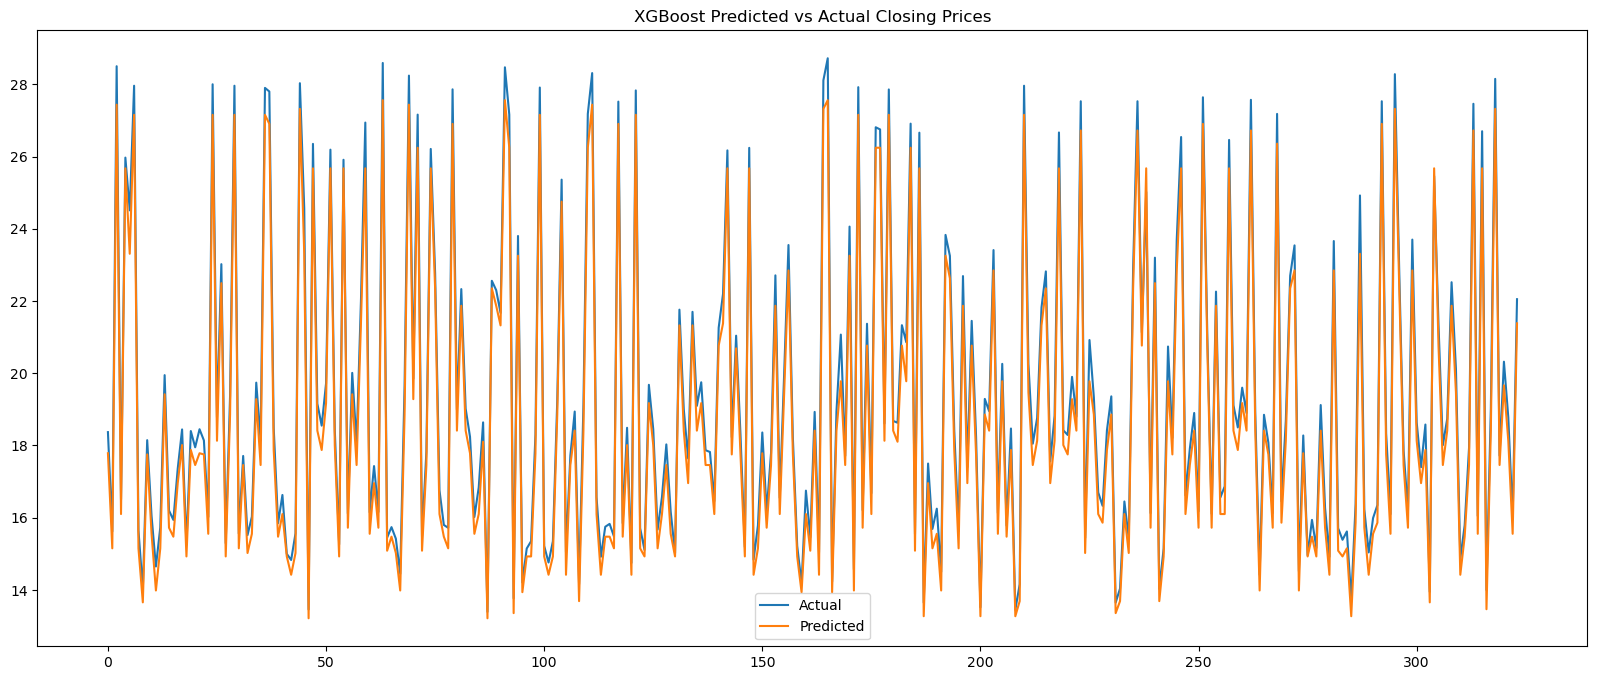

In [478]:
# Plot predicted vs. actual closing prices
plt.figure(figsize=(20,8))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title("XGBoost Predicted vs Actual Closing Prices")
plt.legend()
plt.show()

In [ ]:
# As you can see the model accuracy has significantly improved using optimal hyperparameters in particular reg:squarederror which by design is meant to minimize the mean squared error between the predicted and actual values . The optimal hyperparameters were selected through a process of trial and error.
